In [2]:
# Importing key libraries 
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults 
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tools.eval_measures import rmse,mse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Import Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [6]:
# Load dataset
df = pd.read_excel('Population.xlsx',index_col='Year',parse_dates=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29 entries, 1993-01-01 to 2021-01-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Population  29 non-null     int64
dtypes: int64(1)
memory usage: 464.0 bytes


In [7]:
df['Population'] = df['Population'].astype(float)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29 entries, 1993-01-01 to 2021-01-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Population  29 non-null     float64
dtypes: float64(1)
memory usage: 464.0 bytes


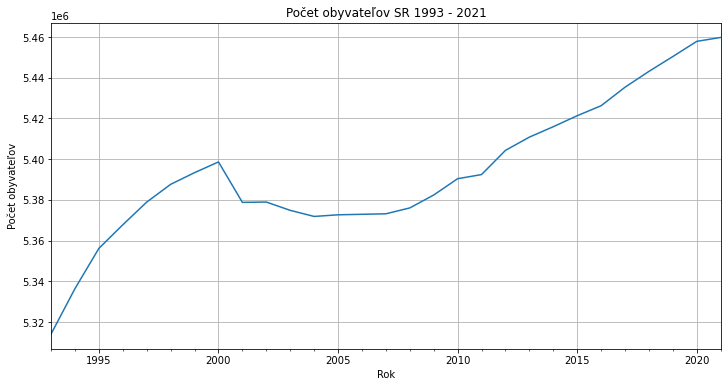

In [9]:
#Data Plot
title = 'Počet obyvateľov SR 1993 - 2021'
xlabel = 'Rok'
ylabel = 'Počet obyvateľov'

ax = df['Population'].plot(figsize=(12,6),title=title,grid=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.autoscale(axis='x',tight=True)

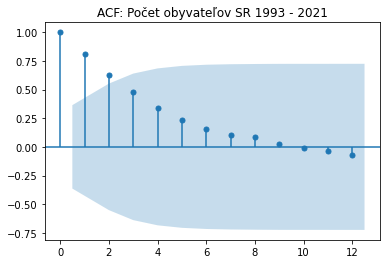

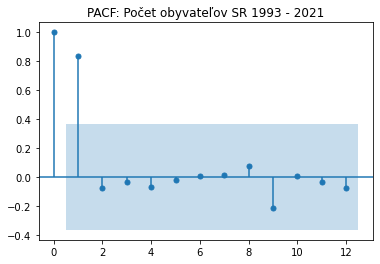

In [10]:
#ACF plot
title = 'ACF: Počet obyvateľov SR 1993 - 2021'
lags = 12
plot_acf(df['Population'],title=title,lags=lags);

#PACF plot
title = 'PACF: Počet obyvateľov SR 1993 - 2021'
lags = 12
plot_pacf(df['Population'],title=title,lags=lags);

In [11]:
#Confirming non-statiotarity with adf_test
adf_test(df['Population'])

Augmented Dickey-Fuller Test: 
ADF test statistic       0.095597
p-value                  0.965759
# lags used              3.000000
# observations          25.000000
critical value (1%)     -3.723863
critical value (5%)     -2.986489
critical value (10%)    -2.632800
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


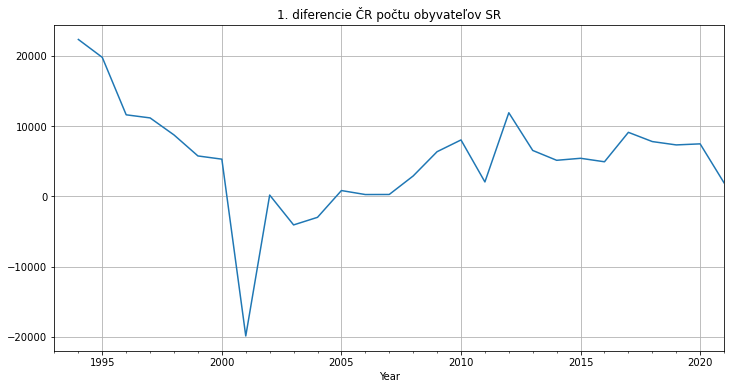

In [12]:
#Differencing data due to non stationarity - 1st difference
df['d1'] = diff(df['Population'],k_diff=1)
title = '1. diferencie ČR počtu obyvateľov SR'
df['d1'].plot(grid=True, title=title, figsize=(12,6));

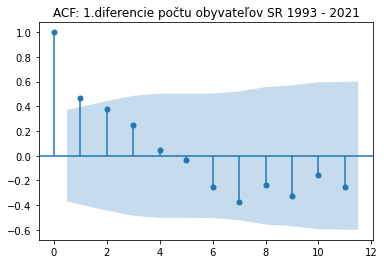

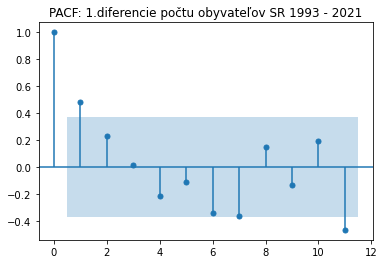

In [60]:
#ACF plot for 1st difference
title='ACF: 1.diferencie počtu obyvateľov SR 1993 - 2021'
lags=12
plot_acf(df['d1'].dropna(),title=title,lags=np.arange(lags));

#PACF plot for 1st difference
title='PACF: 1.diferencie počtu obyvateľov SR 1993 - 2021'
lags=12
plot_pacf(df['d1'].dropna(),title=title,lags=np.arange(lags));

In [61]:
#Confirming non-statiotarity after 1st differencing with adf_test
adf_test(df['d1'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -2.287329
p-value                  0.176087
# lags used              2.000000
# observations          25.000000
critical value (1%)     -3.723863
critical value (5%)     -2.986489
critical value (10%)    -2.632800
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


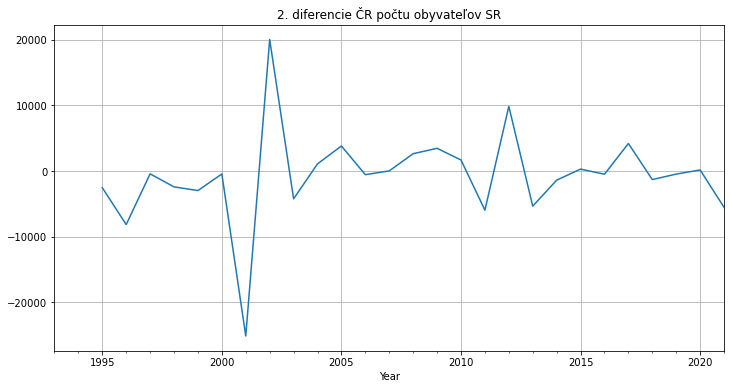

In [14]:
#Differencing data due to non stationarity - 2nd difference
df['d2'] = diff(df['Population'],k_diff=2)
title = '2. diferencie ČR počtu obyvateľov SR'
df['d2'].plot(grid=True, title=title, figsize=(12,6));

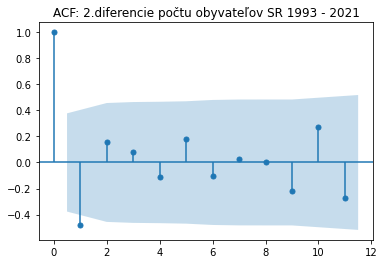

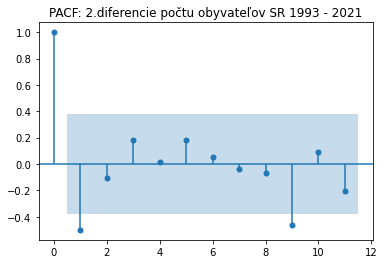

In [15]:
#ACF plot for 2nd difference
title='ACF: 2.diferencie počtu obyvateľov SR 1993 - 2021'
lags=12
plot_acf(df['d2'].dropna(),title=title,lags=np.arange(lags));

#PACF plot for 2nd difference
title='PACF: 2.diferencie počtu obyvateľov SR 1993 - 2021'
lags=12
plot_pacf(df['d2'].dropna(),title=title,lags=np.arange(lags));

In [17]:
#Confirming non-statiotarity after 2nd differencing with adf_test
adf_test(df['d2'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -8.299753e+00
p-value                 4.048323e-13
# lags used             0.000000e+00
# observations          2.600000e+01
critical value (1%)    -3.711212e+00
critical value (5%)    -2.981247e+00
critical value (10%)   -2.630095e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [18]:
#Running auto_arima function which measures many different models
stepwise_fit = auto_arima(df['Population'], start_p=1, start_q=1,
                          max_p=4, max_q=4,
                          seasonal=False,
                          d=2,
                          trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=564.511, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=559.794, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=562.583, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=562.262, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=558.165, Time=0.00 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.111 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   29
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -278.082
Date:                Sun, 20 Feb 2022   AIC                            558.165
Time:                        12:55:21   BIC                            559.460
Sample:                             0   HQIC                           558.550
                                 - 29                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        4.8e+07   6.47e+06      7.424      0.000    3.53e+07    6.07e+07
===================================================================================
Ljung-Box (L1) (Q):                   7.00   Jarque-Bera (JB):                28.99
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.07   Skew:                            -0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
# Splitting into train and test period
train = df.iloc[:23]
test = df.iloc[23:]

In [20]:
#Checking the model after splitting

model = ARIMA(train['Population'],order=(0,2,0))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D2.Population   No. Observations:                   21
Model:                 ARIMA(0, 2, 0)   Log Likelihood                -218.403
Method:                           css   S.D. of innovations           7952.046
Date:                Sun, 20 Feb 2022   AIC                            440.805
Time:                        13:18:14   BIC                            442.894
Sample:                    01-01-1995   HQIC                           441.259
                         - 01-01-2015                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -804.7619   1735.279     -0.464      0.643   -4205.846    2596.322
==============================================================================
"""

In [21]:
#Predictions calculation
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(0,2,0) Test predictions')

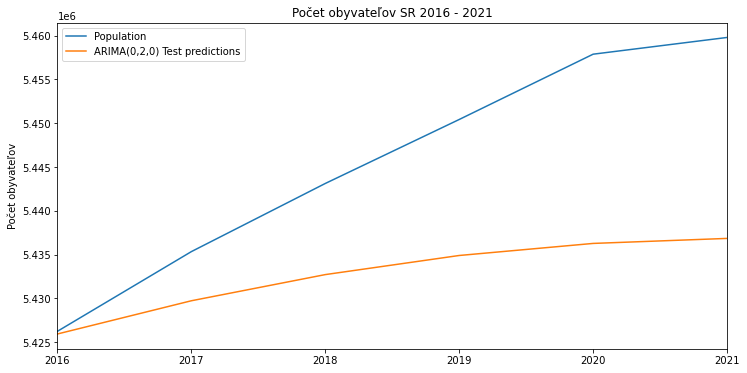

In [22]:
#Plotting predictions vs. expected data
title = 'Počet obyvateľov SR 2016 - 2021'
ylabel='Počet obyvateľov'
xlabel='' # we don't really need a label here

ax = test['Population'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [23]:
# predicted vs. expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['Population'][i]}")

predicted=5425944.238, expected=5426252.0
predicted=5429734.714, expected=5435343.0
predicted=5432720.429, expected=5443120.0
predicted=5434901.381, expected=5450421.0
predicted=5436277.571, expected=5457873.0
predicted=5436849.0  , expected=5459781.0


In [28]:
#MSE and RMSE calculation
error = mse(test['Population'], predictions)
print(f'ARIMA(0,2,0) MSE Error: {error:11.10}')
error = rmse(test['Population'], predictions)
print(f'ARIMA(0,2,0) RMSE Error: {error:11.10}')

ARIMA(0,2,0) MSE Error: 228799401.1
ARIMA(0,2,0) RMSE Error: 15126.11652


In [25]:
#Retraining the model on full dataset
model = ARIMA(df['Population'],order=(0,2,0))
results = model.fit()
forecast = results.predict(len(df),len(df)+8,typ='levels').rename('ARIMA(0,2,0) Forecast')

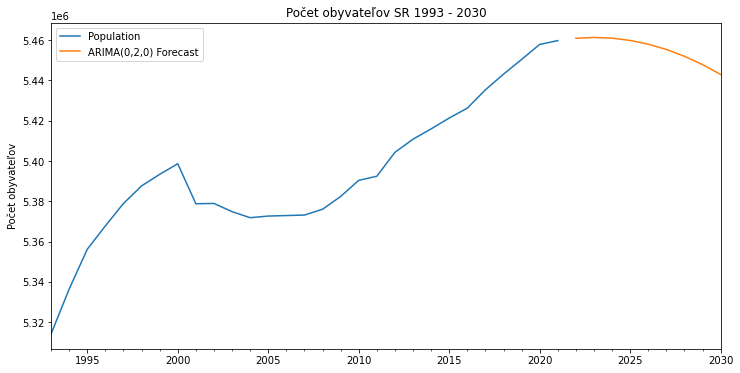

In [26]:
# Plot predictions against known values
title = 'Počet obyvateľov SR 1993 - 2030'
ylabel='Počet obyvateľov'
xlabel='' # we don't really need a label here

ax = df['Population'].plot(legend=True,figsize=(12,6),title=title)
forecast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [27]:
forecast

2022-01-01    5.460934e+06
2023-01-01    5.461331e+06
2024-01-01    5.460973e+06
2025-01-01    5.459860e+06
2026-01-01    5.457992e+06
2027-01-01    5.455369e+06
2028-01-01    5.451990e+06
2029-01-01    5.447856e+06
2030-01-01    5.442966e+06
Freq: AS-JAN, Name: ARIMA(0,2,0) Forecast, dtype: float64